# pIC50 Test

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import seaborn as sns
import malt
import pandas as pd
import dgllife
import math

Using backend: pytorch


In [3]:
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from pathlib import Path
f = f'{Path.home()}/dev/choderalab/data/data/moonshot_fluorescence_titration_curves.csv'
import pandas as pd
df = pd.read_csv(f, index_col=0).dropna()
# df['ic50'] *= 1e4
df['pic50'] = df['ic50'].apply(lambda x: -math.log10(x))
df = df.rename(
    {
        'concentration': 'c',
        'inhibition': 'inhib',
        'pic50': 'y',
    }, 
    axis=1
)
df = df.drop_duplicates('SMILES')

from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer

def parse_graph(smiles):
    return smiles_to_bigraph(
        smiles = smiles,
        node_featurizer = CanonicalAtomFeaturizer(),
        edge_featurizer = CanonicalBondFeaturizer()
    )

from malt import Dataset, AssayedMolecule
from tqdm import tqdm

molecules = []
for smiles, mol_metadata in tqdm(df.groupby('SMILES')):
    molecule = AssayedMolecule(
        smiles = smiles,
        metadata = {'fluorescence': mol_metadata.drop('SMILES', axis=1).to_dict('records')}
    )
    molecules.append(molecule)
    
# create dataset
data = Dataset(molecules)
data.shuffle(seed=2666)
ds_tr, ds_te = data.split([8, 2])

100%|█████████████████████████████████████| 1606/1606 [00:01<00:00, 1557.78it/s]


Make model

In [4]:
model_choice = 'gp' # 'nn'
if model_choice == "gp":
    model = malt.models.supervised_model.GaussianProcessSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=32,
            hidden_features=32,
        ),
        regressor=malt.models.regressor.ExactGaussianProcessRegressor(
            in_features=32, out_features=2,
        ),
        likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
    ).cuda()

elif model_choice == "nn":
    model = malt.models.supervised_model.SimpleSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=32,
        ),
        regressor=malt.models.regressor.NeuralNetworkRegressor(
            in_features=32, out_features=1,
        ),
        likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood(),
    ).cuda()

Train and evaluate.

In [6]:
trainer = malt.trainer.get_default_trainer(
    without_player=True,
    batch_size=len(ds_tr), # len(ds_tr),
    n_epochs=1600,
    learning_rate=1e-3
)

model = trainer(model, ds_tr)

r2 = malt.metrics.supervised_metrics.R2()(model, ds_te)
print(r2)

rmse = malt.metrics.supervised_metrics.RMSE()(model, ds_te)
print(rmse)

tensor(0.1266, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(1.0307, device='cuda:0', grad_fn=<SqrtBackward0>)


c:\users\micha\dev\choderalab\malt\malt\metrics\base_metrics.py:10: UserWarning: Using a target size (torch.Size([321])) that is different to the input size (torch.Size([321, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.sqrt(torch.nn.functional.mse_loss(target, input))


In [7]:
r2 = malt.metrics.supervised_metrics.R2()(model, ds_tr)
print(r2)

rmse = malt.metrics.supervised_metrics.RMSE()(model, ds_tr)
print(rmse)

tensor(0.7747, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(1.0840, device='cuda:0', grad_fn=<SqrtBackward0>)


c:\users\micha\dev\choderalab\malt\malt\metrics\base_metrics.py:10: UserWarning: Using a target size (torch.Size([1284])) that is different to the input size (torch.Size([1284, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.sqrt(torch.nn.functional.mse_loss(target, input))


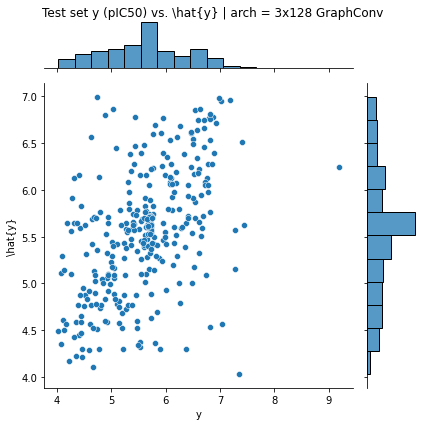

In [12]:
import matplotlib.pyplot as plt

g, y = ds_te.batch()
y_hat = model.condition(g).mean

# idx = torch.argmax(y.ravel() - y_hat)
# y = torch.cat([y[:idx], y[idx+1:]])
# y_hat = torch.cat([y_hat[:idx], y_hat[idx+1:]])

g = sns.jointplot(
    x = y.ravel().tolist(),
    y = y_hat.ravel().tolist(),
)
g.set_axis_labels('y', '\hat{y}')
g.fig.suptitle('Test set y (pIC50) vs. \hat{y} | arch = 3x128 GraphConv')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

In [13]:
from scipy.stats import pearsonr

pearsonr(y.ravel().tolist(), y_hat.tolist())

(0.49855661624980613, 1.4231587899330497e-21)

## ESOL experiments

In [93]:
import torch
import dgl
import malt
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--data", type=str, default="esol")
parser.add_argument("--model", type=str, default="gp")

args = parser.parse_args([])

data = getattr(malt.data.collections, args.data)()


def test(data):
    
    data.shuffle(seed=1)
    ds_tr, ds_te = data.split([8, 2])

    if args.model == "gp":
        model = malt.models.supervised_model.GaussianProcessSupervisedModel(
            representation=malt.models.representation.DGLRepresentation(
                out_features=32, hidden_features=32,
            ),
            regressor=malt.models.regressor.ExactGaussianProcessRegressor(
                in_features=32, out_features=2,
            ),
            likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
        ).cuda()


    elif args.model == "nn":
        model = malt.models.supervised_model.SimpleSupervisedModel(
            representation=malt.models.representation.DGLRepresentation(
                out_features=32,
            ),
            regressor=malt.models.regressor.NeuralNetworkRegressor(
                in_features=32, out_features=1,
            ),
            likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood(),
        ).cuda()


    trainer = malt.trainer.get_default_trainer(
        without_player=True,
        batch_size=len(ds_tr),
        n_epochs=100,
        learning_rate=1e-3,
    )
    model = trainer(model, ds_tr)

    # model_cpu = model.to('cpu')
    r2 = malt.metrics.supervised_metrics.R2()(model, ds_te)

    # rmse = malt.metrics.supervised_metrics.RMSE()(model, ds_te)
    # print(rmse)
    return r2

Processing dgl graphs from scratch...
Processing molecule 1000/1128


In [94]:
from tqdm import tqdm
r2s = []
for _ in tqdm(range(20)):
    r2s.append(
        test(data).item()
    )

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:54<00:00, 14.73s/it]


Text(0.5, 1.0, 'hand-coded: testing')

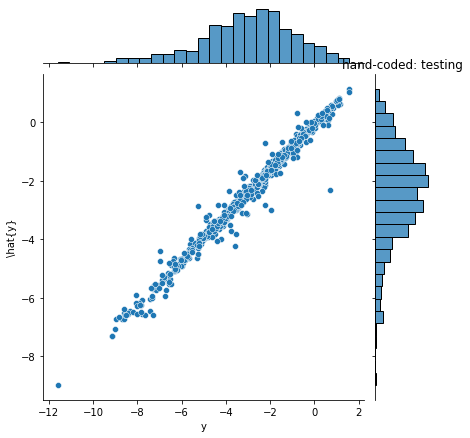

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

ds_plot = deepcopy(ds_tr)
ds_plot_loader = ds_plot.view(batch_size=len(ds_plot))
g, y = next(iter(ds_plot_loader))
y_hat = model.condition(g).mean
g = sns.jointplot(x = ds_plot.batch(by=['y']).ravel().tolist(), y = (y_hat * 0.8).tolist())
g.set_axis_labels('y', '\hat{y}')
plt.title('hand-coded: testing')

In [53]:
from scipy.stats import pearsonr

pearsonr(
    ds_te.batch(by=['y']).ravel().tolist(), y = (y_hat * 0.8).tolist()
)

(0.9558257872801152, 1.4668193117261497e-120)

In [51]:
from malt.metrics.base_metrics import r2

r2(
    ds_te.batch(by=['y']), (y_hat * 0.95)
)

tensor(0.8804, device='cuda:0', grad_fn=<RsubBackward1>)